### Exercise 1: Connected Component Labeling (Etiquetage en composantes connexes)

- Goal: Assign a unique label (integer ID) to each distinct connected object in a binary image using 4-connectivity .

- Theory:
    - We treat the image as a graph where pixels are nodes and neighbors are edges.
    - We iterate through every pixel.
    - If we find a foreground pixel (255) that hasn't been labeled yet:
        1. Assign it a new current_label.
        2. Push it onto a stack.
        3. Perform a Depth-First Search (DFS) (or Breadth-First Search) to find all connected neighbors (4-neighbors: up, down, left, right).
        4. Assign the same label to these neighbors and add them to the stack.
    - Repeat until all pixels are visited.

Implementation Note: The PDF provides a pseudo-code using a stack ("Pile") . 

I will implement this iteratively to avoid Python's recursion depth limits.

Number of connected components found: 5582


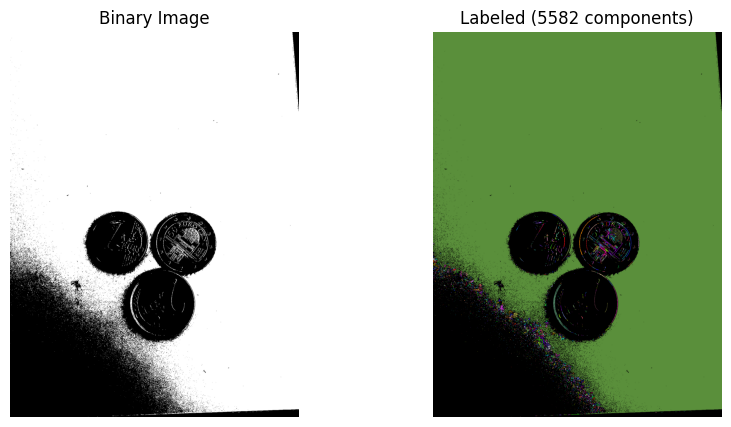

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys


def cc_label(binary_image):

    h, w = binary_image.shape
    labels = np.zeros((h, w), dtype=np.int32)
    current_label = 0
    
    # Define 4-connectivity neighbors (up, down, left, right)
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    # Iterate over every pixel
    for y in range(h):
        for x in range(w):
            # If pixel is foreground and not yet labeled
            if binary_image[y, x] == 255 and labels[y, x] == 0:
                current_label += 1
                
                # Start DFS using a stack
                stack = [(y, x)]
                labels[y, x] = current_label
                
                while stack:
                    cy, cx = stack.pop()
                    
                    # Check all 4 neighbors
                    for dy, dx in neighbors:
                        ny, nx = cy + dy, cx + dx
                        
                        # Check bounds
                        if 0 <= ny < h and 0 <= nx < w:
                            # If neighbor is foreground and not labeled
                            if binary_image[ny, nx] == 255 and labels[ny, nx] == 0:
                                labels[ny, nx] = current_label
                                stack.append((ny, nx))
                                
    return labels, current_label

def label_to_color(labels):

    h, w = labels.shape
    num_labels = np.max(labels)
    
    # Map label indices to random colors
    colors = np.random.randint(0, 255, (num_labels + 1, 3), dtype=np.uint8)
    colors[0] = [0, 0, 0] # Background is black
    
    # Create color image
    output_color = np.zeros((h, w, 3), dtype=np.uint8)
    
    for y in range(h):
        for x in range(w):
            idx = labels[y, x]
            if idx > 0:
                output_color[y, x] = colors[idx]
                
    return output_color

#test

img = cv2.imread('img/coins.png', cv2.IMREAD_GRAYSCALE)

# Threshold to get strict binary image (0 or 255)
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# Perform Labeling
labels, num_components = cc_label(binary)
print(f"Number of connected components found: {num_components}")

# Visualize
color_labels = label_to_color(labels)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Binary Image")
plt.imshow(binary, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Labeled ({num_components} components)")
plt.imshow(color_labels)
plt.axis('off')

plt.show()

### Exercise 2: Area Filter

- Goal: Implement an area filter to remove connected components smaller than a specific pixel count .

- Theory: An area filter cleans the image based on object size rather than just intensity or geometry.

 1. Compute the area (number of pixels) for each component label found in Exercise 1.

 2. If area(label) < threshold, remove that component (set its pixels to 0).

 3. Otherwise, keep it (set its pixels to 255).

Original components: 5582
Components after filtering (size >= 150): 21


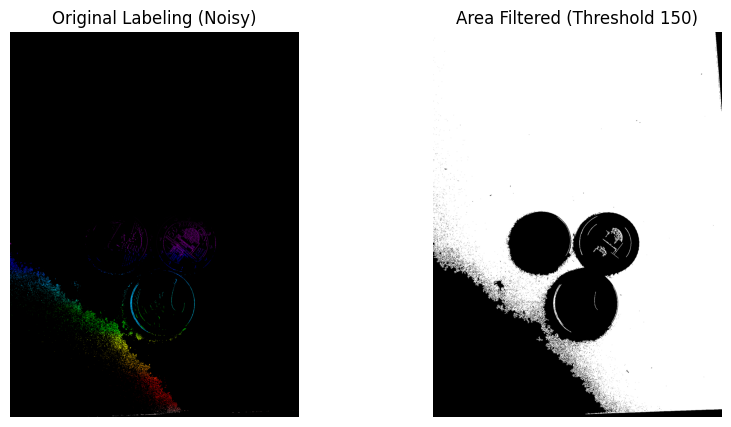

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def cc_area_filter(labels, size_threshold):

    # 1. Calculate the area (pixel count) for each label
    # np.bincount is efficient for this: index i stores count of value i
    # minlength makes sure that it covers all labels up to the max label
    areas = np.bincount(labels.flatten())
    
    # 2. Identify which labels meet the threshold
    # Create a boolean mask: True if area >= threshold, False otherwise
    # important note: areas[0] is the background count, we usually want to ignore it or handle it separately.
    # 'valid_labels' is a boolean array where index is the label ID.
    valid_labels = areas >= size_threshold

    valid_labels[0] = False
    
    # 3. Construct the filtered image
    # boolean mask as a lookup table. 
    # valid_labels[labels] maps every pixel's label ID to True/False.
    output_mask = valid_labels[labels]
    
    # Convert boolean True/False to 255/0
    filtered_image = output_mask.astype(np.uint8) * 255
    
    # Calculate how many components remain (excluding background)
    num_remaining = np.sum(valid_labels)
    
    return filtered_image, num_remaining

# test

# I reuse the 'labels' variable from your previous execution
# rerun the previous block

# Apply area filter
# Try a threshold, e.g., 100 pixels. 
# Adjust this value based on the size of the noise vs the coins.
threshold = 150 
filtered_binary, count = cc_area_filter(labels, size_threshold=threshold)

print(f"Original components: {np.max(labels)}")
print(f"Components after filtering (size >= {threshold}): {count}")

# Display results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Labeling (Noisy)")
plt.imshow(labels, cmap='nipy_spectral') # using "nipy_spectral" colormap that highlights noise
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Area Filtered (Threshold {threshold})")
plt.imshow(filtered_binary, cmap='gray')
plt.axis('off')

plt.show()

### Exercise 3: Two-Pass Labeling
- Goal: Implement the Two-Pass connected component labeling algorithm .

- Theory:
The DFS/BFS approach used in Exercise 1 is simple but can be slow due to random memory access. The Two-Pass algorithm is more cache-friendly as it processes the image linearly.
1. First Pass (Assign temporary labels):
    - Iterate through pixels. If a pixel is foreground ($255$):
        - Check its neighbors (usually Top and Left for 4-connectivity).
        - Case A: No neighbors have labels $\rightarrow$ Assign a new label.
        - Case B: One neighbor has a label $\rightarrow$ Assign that label.
        - Case C: Both neighbors have different labels $\rightarrow$ Assign the smaller label and record the equivalence (e.g., "Label 5 is equivalent to Label 2") in a disjoint-set (union-find) structure.
2. Resolve Equivalence: Flatten the equivalence structure so every label points to its canonical root (e.g., if $5 \rightarrow 2$ and $2 \rightarrow 1$, then $5 \rightarrow 1$).
3. Second Pass (Relabel):Iterate through pixels again. Replace every temporary label with its canonical root label.

Two-Pass Labeling Found: 5582 components


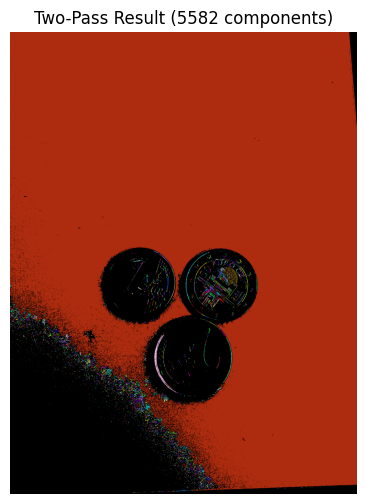

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def cc_two_pass_label(binary_image):

    h, w = binary_image.shape
    labels = np.zeros((h, w), dtype=np.int32)
    next_label = 1
    
    # Equivalence table (Union-Find structure)
    # parent[i] stores the parent of label i. Initially parent[i] = i.
    # We'll use a dictionary or list. List is faster if we estimate max labels.
    # Let's use a large list and resize if needed, or just a dictionary for simplicity in Python.
    parent = {}

    def find(i):
        """Find root of label i with path compression."""
        if parent[i] == i:
            return i
        parent[i] = find(parent[i]) # Path compression
        return parent[i]

    def union(i, j):
        """Union two labels."""
        root_i = find(i)
        root_j = find(j)
        if root_i != root_j:
            # Union by setting one root to be the child of the other
            # Convention: smaller label becomes parent
            if root_i < root_j:
                parent[root_j] = root_i
            else:
                parent[root_i] = root_j

    # --- PASS 1: Assign Temporary Labels & Record Equivalences ---
    for r in range(h):
        for c in range(w):
            if binary_image[r, c] == 255: # Foreground
                # Get neighbors (Top and Left for 4-connectivity)
                # Note: We need to check bounds
                neighbors = []
                if r > 0 and labels[r-1, c] > 0: # Top
                    neighbors.append(labels[r-1, c])
                if c > 0 and labels[r, c-1] > 0: # Left
                    neighbors.append(labels[r, c-1])
                
                if not neighbors:
                    # New component
                    labels[r, c] = next_label
                    parent[next_label] = next_label
                    next_label += 1
                else:
                    # Assign the smallest neighbor label
                    min_label = min(neighbors)
                    labels[r, c] = min_label
                    
                    # Record equivalence for all other neighbors
                    for label in neighbors:
                        if label != min_label:
                            union(min_label, label)

    # --- RESOLVE EQUIVALENCES ---
    # Create a mapping from old label -> canonical root label
    # This optimizes the second pass
    mapping = {}
    for i in range(1, next_label):
        mapping[i] = find(i)
        
    # Optional: Renumber labels consecutively (1, 2, 3...) for cleaner output
    # This maps canonical roots to 1..N
    final_mapping = {}
    current_final = 1
    sorted_roots = sorted(list(set(mapping.values())))
    for root in sorted_roots:
        final_mapping[root] = current_final
        current_final += 1
        
    # Combine the mappings: old_label -> root -> new_consecutive_label
    total_mapping = np.zeros(next_label, dtype=np.int32)
    for i in range(1, next_label):
        total_mapping[i] = final_mapping[mapping[i]]

    # --- PASS 2: Relabel Image ---
    # Use numpy efficient indexing to replace all values at once
    final_labels = total_mapping[labels]
    
    num_components = current_final - 1
    return final_labels, num_components

# --- Helper function ---
def label_to_color(labels):
    h, w = labels.shape
    num_labels = np.max(labels)
    # Map label indices to random colors
    colors = np.random.randint(0, 255, (num_labels + 1, 3), dtype=np.uint8)
    colors[0] = [0, 0, 0] # Background is black
    # Create color image
    output_color = np.zeros((h, w, 3), dtype=np.uint8)
    for y in range(h):
        for x in range(w):
            idx = labels[y, x]
            if idx > 0:
                output_color[y, x] = colors[idx]
    return output_color

# --- Test ---
# Reuse the binary image from previous exercises
if 'binary' not in locals():
    # Fallback if variable lost
    img = cv2.imread('img/coins.png', cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

labels_2pass, num_2pass = cc_two_pass_label(binary)

print(f"Two-Pass Labeling Found: {num_2pass} components")

# Visualize
color_labels_2pass = label_to_color(labels_2pass)

plt.figure(figsize=(6, 6))
plt.title(f"Two-Pass Result ({num_2pass} components)")
plt.imshow(color_labels_2pass)
plt.axis('off')
plt.show()

### Exercise 4: Otsu's Thresholding
- Goal: Implement Otsu's method for automatic image thresholding .
- Theory:
Thresholding converts a grayscale image into a binary one by splitting pixels into two classes: 
background ($C_0$) and foreground ($C_1$). 
Otsu's method automatically finds the optimal threshold $t$ that minimizes the intra-class variance (the spread of pixel values within each class) or, equivalently, maximizes the inter-class variance (the separation between the two classes).

- We iterate through all possible threshold values $t$ (0 to 255):
    1. Calculate the probability (weight) of each class: $\omega_0(t)$ and $\omega_1(t)$.
    2. Calculate the mean intensity of each class: $\mu_0(t)$ and $\mu_1(t)$.
    3. Compute the inter-class variance $\sigma_b^2(t) = \omega_0(t) \omega_1(t) (\mu_0(t) - \mu_1(t))^2$.
    4. The optimal threshold $t^*$ is the one that maximizes $\sigma_b^2(t)$.

Optimal Otsu Threshold found: 140


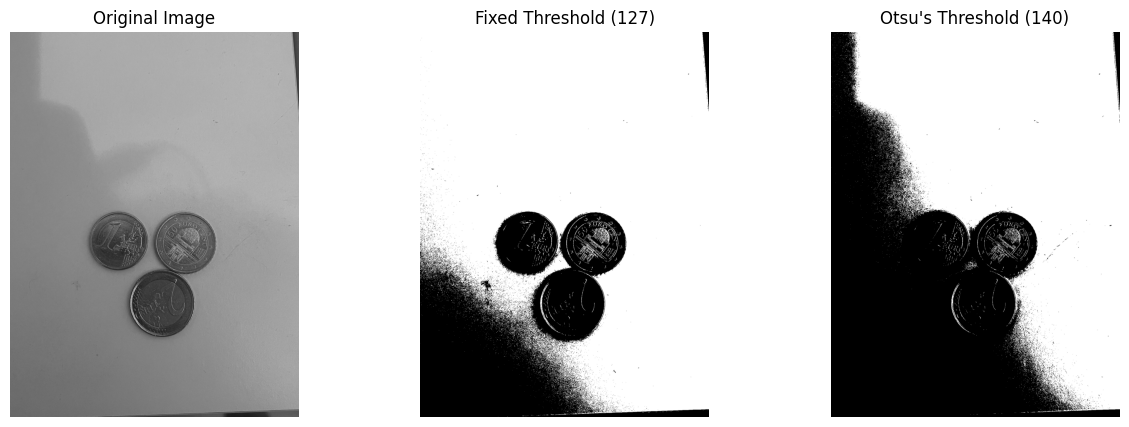

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def otsu_threshold(image):

    # 1. Compute histogram
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist = hist.flatten()
    
    # Normalize histogram to get probabilities
    total_pixels = image.size
    prob = hist / total_pixels
    
    # Variables to track maximum variance and optimal threshold
    max_variance = 0
    optimal_threshold = 0
    
    # Pre-compute global mean intensity
    global_mean = np.sum(np.arange(256) * prob)
    
    # Iterate through all possible thresholds
    # We maintain running sums to avoid recomputing everything inside the loop
    w0 = 0
    sum_0 = 0
    
    for t in range(256):
        w0 += prob[t]
        if w0 == 0:
            continue
            
        w1 = 1 - w0
        if w1 == 0:
            break
            
        sum_0 += t * prob[t]
        
        # Mean of background (mu0) and foreground (mu1)
        mu0 = sum_0 / w0
        mu1 = (global_mean - sum_0) / w1
        
        # Inter-class variance
        variance = w0 * w1 * ((mu0 - mu1) ** 2)
        
        # Check if new max found
        if variance > max_variance:
            max_variance = variance
            optimal_threshold = t
            
    # Apply the optimal threshold
    # Note: Pixels > threshold become foreground (255)
    binary_image = (image > optimal_threshold).astype(np.uint8) * 255
    
    return binary_image, optimal_threshold

# --- Test ---
# Load grayscale image
img = cv2.imread('img/coins.png', cv2.IMREAD_GRAYSCALE)

# Apply Otsu's Thresholding
otsu_binary, thresh_val = otsu_threshold(img)

print(f"Optimal Otsu Threshold found: {thresh_val}")

# Compare with a standard fixed threshold (e.g., 127)
_, fixed_binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# Display results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title(f"Fixed Threshold (127)")
plt.imshow(fixed_binary, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title(f"Otsu's Threshold ({thresh_val})")
plt.imshow(otsu_binary, cmap='gray')
plt.axis('off')

plt.show()

### Exercise 5: Region Growing
- Goal: Implement a Region Growing algorithm .

- Theory:Region Growing is a segmentation method that starts from a "seed" pixel and expands the region by adding neighboring pixels that are "homogeneous" (similar enough) to the current region.

- Algorithm Steps :
    1. Initialize: Start with a seed point $S$. 
    2. Create a region list/mask and add $S$ to it.Iterate: For every pixel $P$ in the region to process:
        - Check its neighbors $N$.
        - For each neighbor $N$, if it's not already in a region AND it satisfies the homogeneity predicate (e.g., $|Intensity(N) - Mean(Region)| < Threshold$):
            - Add $N$ to the region.
            - Update the region's statistics (mean).
            - Add $N$ to the list of pixels to process.
    3. Repeat: Continue until no more neighbors can be added.
    
    Implementation Note:The instructions mention checking homogeneity against the region mean. For efficiency, we can check against the initial seed value or a running average. We'll use a simple absolute difference from the seed value or current region mean.

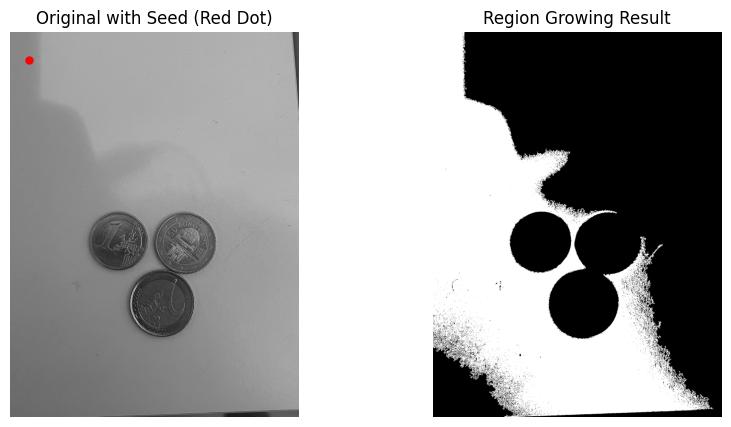

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def region_growing(image, seed, threshold):

    h, w = image.shape
    visited = np.zeros((h, w), dtype=np.bool_)
    region_mask = np.zeros((h, w), dtype=np.uint8)
    
    # Initialize list of points to process with the seed
    # Use a list as a queue/stack
    process_list = [seed]
    
    # Mark seed as visited and part of region
    visited[seed] = True
    region_mask[seed] = 255
    
    # Keep track of region mean (optional, but robust)
    # Ideally, we update this dynamically. For simplicity, we can use the seed value
    # or a running average. Let's use running sum for mean calculation.
    region_sum = float(image[seed])
    region_count = 1
    
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    while process_list:
        cy, cx = process_list.pop(0) # pop(0) -> BFS behavior (grows in layers)
        
        current_mean = region_sum / region_count
        
        for dy, dx in neighbors:
            ny, nx = cy + dy, cx + dx
            
            # Check bounds
            if 0 <= ny < h and 0 <= nx < w:
                if not visited[ny, nx]:
                    # Homogeneity Criteria: Difference from Region Mean
                    pixel_val = image[ny, nx]
                    if abs(int(pixel_val) - current_mean) <= threshold:
                        # Add to region
                        visited[ny, nx] = True
                        region_mask[ny, nx] = 255
                        process_list.append((ny, nx))
                        
                        # Update statistics
                        region_sum += pixel_val
                        region_count += 1
                        
    return region_mask

# --- Test ---
img = cv2.imread('img/coins.png', cv2.IMREAD_GRAYSCALE)

# Pick a seed point manually.
# For 'coins.png', let's pick a point inside one of the coins.
# You might need to adjust these coordinates based on your specific image.
# (y, x) format
seed_point = (150, 100) # Example coordinate inside a coin

# Check if seed is valid
if seed_point[0] < img.shape[0] and seed_point[1] < img.shape[1]:
    # Run Region Growing
    # Threshold determines how strictly pixels must match the region
    reg_grow_result = region_growing(img, seed_point, threshold=20)

    # Display
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original with Seed (Red Dot)")
    plt.imshow(img, cmap='gray')
    plt.plot(seed_point[1], seed_point[0], 'r.', markersize=10) # Plot seed
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Region Growing Result")
    plt.imshow(reg_grow_result, cmap='gray')
    plt.axis('off')

    plt.show()
else:
    print("Seed point is out of bounds. Please adjust coordinates.")